## Real data

In [1]:
import sys
sys.path.insert(0,'..')

from emsim import training as tr
from emsim import emnet
from emsim import emsim_utils

import struct
import gc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import scipy.optimize as optimize
from glob import glob

from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from PIL import Image
import tifffile

/home/jrenner/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## New edge data (.tif format)

In [2]:
img_path = '/home/jrenner/local/jerenner/emsim/CDS_DS_Lin_30s_1024fr.0001-0001-1024.tif'

In [3]:
vol = None

with tifffile.TiffFile(img_path) as tif:
    # Memory-map the TIFF file as an array
    # The array doesn't actually load the entire file into memory, just maps it.
    vol = tif.asarray(out='memmap')

    # Create the summed image in chunks
    chunk_size = 100
    total_slices = vol.shape[0]
    summed_image = np.zeros(vol.shape[1:], dtype=np.float32)

    for start_slice in range(0, total_slices, chunk_size):
        end_slice = min(start_slice + chunk_size, total_slices)
        summed_image += vol[start_slice:end_slice].sum(axis=0)

print(summed_image.shape)

(3240, 2304)


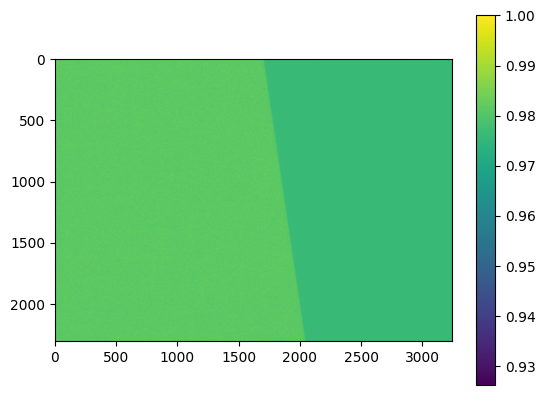

In [4]:
plt.imshow(summed_image.transpose()/np.max(summed_image))
plt.colorbar()

### Find the edge

In [ ]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[xmin:xmax,nrow]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    L0 = np.mean(ydata[ydata > np.mean(ydata)])
    p0 = [L0, x0, -1, 0]
    bounds = ((0.5*L0, xmin, -10, -0.2), (2*L0, xmax, 10, 0.2))
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox', bounds=bounds) #, bounds=((-max(ydata), x0-20, -np.inf, 0), (max(ydata), x0+20, np.inf, 200)))
    
    return popt

In [ ]:
# Plot a single row
nrow = 0
xmin = 1600
xmax = 2000
ydata = summed_image[xmin:xmax,nrow]
xdata = np.arange(xmin,xmax)

plt.plot(xdata,ydata)

In [ ]:
nrow = 0
baseline = np.average(summed_image[1800:,0])
xmin = 1400
xmax = 2000
ydata = summed_image - baseline
ydata /= np.max(ydata)
xdata = np.arange(xmin,xmax)

try:
    popt = fit_scurve(ydata,nrow,1685,rng=100)
except:
    print("** Fit failed for row",nrow)
    L,k,b = None,None,None
    x0 = -1
print("Params (L, x0, k, b):",*popt)

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit')    
plt.plot(xdata,ydata[xmin:xmax,nrow])

#### Perform the s-curve fit to each row of the entire image

In [ ]:
# Update the summed image
baseline = np.average(summed_image[1800:,nrow])
summed_image = summed_image - baseline
summed_image /= np.max(summed_image)

In [ ]:
x_guess = 1700
x_edges = []
for row in range(summed_image.shape[1]):
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(summed_image,row,x_guess,rng=100)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = -1
    
    # Append this fit result for x0 to the list.
    x_edge = x0 # int(np.round(x0))
    x_edges.append(x_edge)
    
    # Update the guess if the fit was successful (otherwise keep the last guess)
    if(x0 > 0):
        x_guess = int(np.round(x_edge))
        
    print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
x_edges = np.array(x_edges)

In [ ]:
# Set all -1 values as average of left and right values.
i = 1
tol = 5
while(i < len(x_edges)-2):
    v = x_edges[i]
    vleft = x_edges[i-1]
    vright = x_edges[i+1]
    
    # Do not process this value with an invalid value to the right.
    if(vright < 0):
        i += 1
        continue
        
    if(v < 0):
        x_edges[i] = (vleft + vright)/2.
        print("-> vleft = {}, vright = {}, v = {}".format(vleft,vright,v))
        print("-- Set negative x_edge value at i = {} to left/right avg value {}".format(i,(vleft+vright)/2))
    elif(abs(vleft - v) > tol and abs(vright - v) > tol):
        x_edges[i] = (vleft + vright)/2.
        print("-> vleft = {}, vright = {}, v = {}".format(vleft,vright,v))
        print("-- Set outlier x_edge value at i = {} to left/right avg value {}".format(i,(vleft+vright)/2))
        
    i += 1

In [ ]:
img_edge = np.zeros([summed_image.shape[0],summed_image.shape[1]]) #img_th_all.shape)
for row,xedge in zip(range(img_edge.shape[1]),x_edges):
    iedge = int(np.round(xedge))
    img_edge[iedge,row] = 1

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.imshow(summed_image.transpose())
plt.colorbar()
#plt.imshow(img_edge,alpha=0.1)

ax2 = fig.add_subplot(122)
plt.imshow(img_edge.transpose())
plt.colorbar()

### Fit the edge to a straight line

In [ ]:
def line(x, m, b):
    y = m*x + b
    return y

In [ ]:
# Compute the slopes and intercepts.
y1 = 0; y2 = summed_image.shape[1]
x1 = x_edges[0]; x2 = x_edges[-1]
m0 = (y2 - y1) / (x2 - x1)
b0 = y2 - m0*x2

xfit = x_edges
yfit = np.arange(summed_image.shape[1])
p0 = [m0, b0]
popt, pcov = curve_fit(line, xfit, yfit, p0)

plt.imshow(img_edge.transpose())
plt.colorbar()

x = np.linspace(xfit[0], xfit[-1], 1000)
y = line(x, *popt)

plt.plot(x,y, label='fit',color='red',alpha=0.1)
print("Fit line is y = {}x + {}".format(*popt))

In [ ]:
# Final fit values:
mfit = 6.726618999489237
bfit = -11435.748631593482

## Select individual samples

#### First determine the threshold for a hit

In [ ]:
nimg = 0
test_image = vol[nimg]
test_image = np.array(test_image, dtype=np.float32)

In [ ]:
# Histogram the image around the noise region
plt.hist(test_image.flatten(),bins=200,range=[8000,15000])
plt.yscale('log')

In [ ]:
# Choose the threshold
th = 9500
th_image = np.zeros(test_image.shape)
th_image[test_image > th] = 1
plt.imshow(th_image[100:300,100:300])

#### Select the subimages

In [ ]:
# Create a new x_edges based on the line
yline = np.arange(summed_image.shape[1])
xedges_line = np.round((yline - bfit)/mfit)

In [ ]:
plt.imshow(img_edge.transpose())
plt.colorbar()
plt.plot(xedges_line,yline)

In [ ]:
side = 1 # light side; 0 = right, 1 = left

# Determines whether the image is a valid event.
def check_subimage_th(subimg):
    valid = False
    
    # Ensure the maximum pixel index is within some number of pixels of the borders.
    pixel_padding = 2
    max_index = np.unravel_index(subimg.argmax(),subimg.shape)
    valid = (max_index[0] > pixel_padding) and (max_index[0] < subimg.shape[0]-pixel_padding-1) and (max_index[1] > pixel_padding) and (max_index[1] < subimg.shape[1]-pixel_padding-1)
    
    # Ensure there is at least 1 nonzero pixel.
    valid = valid and (len(subimg[subimg > 0]) > 0) 
    
    return valid

def choose_subimages(img, img_th, available_edges, xedges_line, debug=False):

    valid_subimages, valid_subimages_c, valid_subimages_th = [], [], []
    line_m, line_b = [], []

    # Loop until no available edges remain.
    done = (available_edges == -1).all()
    while(not done):

        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)

        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue

        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            
            done = (available_edges == -1).all()
            continue

        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):

            # Construct the subimage.
            xmid = int(np.round(xedges_line[rmid]))
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1

            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):

                # Create the subimage.
                subimg    = img[cstart:cend,rstart:rend]
                subimg_th = img_th[cstart:cend,rstart:rend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[1] - delta)
                jleft = cstart + (arg_max[0] - delta)
                iright = rend + (arg_max[1] - delta)
                jright = cend + (arg_max[0] - delta)

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):

                    # Compute the slopes and intercepts (only b is shifted).
                    m = mfit
                    b = bfit + mfit*cstart - rstart
                    if(debug): 
                        #print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                        #print("m0 = {}, b0 = {}".format(mfit,bfit))
                        #print("m = {}, b = {}".format(m,b))
                        
                        # Make a plot of the image + points + fit.
                        fig = plt.figure()
                        fig.set_figheight(4.0)
                        fig.set_figwidth(8.0)
                        xplt = np.arange(0,2*subimg_halfsize+1,1e-4)
                        yplt = m*xplt + b

                        plt.imshow(subimg.transpose(), extent=[0,2*subimg_halfsize+1,2*subimg_halfsize+1,0])
                        plt.plot(xplt[(yplt >= 0) & (yplt <= 2*subimg_halfsize+1)],yplt[(yplt >= 0) & (yplt <= 2*subimg_halfsize+1)],linewidth=2,color='red')
                        #plt.plot(xfit,yfit,'.',color='red')
                        plt.colorbar()
                        plt.title("m0 = {}, b0 = {},\nm = {}, b = {}".format(mfit,bfit,m,b))
                        plt.savefig("plt/subimg_xmid_{}_rmid_{}.png".format(xmid,rmid))
                        plt.close()
                    
                    # Only save the subimage if the slope is negative for side = 0 or positive for side = 1.
                    # (Note, because y increases downward, the notion of "negative" and "positive" is flipped.)
                    #if(debug): print("side = {}, m = {}".format(side,m))
                    if((side == 0 and m < 0) or (side == 1 and m > 0)):

                        # Save the subimage if the centered subimage is also valid.
                        if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                            #if(debug): print("Centered subimage is valid.")
                            subimg_c = img[jleft:jright,ileft:iright]
                            arg_max_c = np.unravel_index(np.argmax(subimg_c),subimg_c.shape)

                            # Don't save the image if the center pixel is no longer the maximum.
                            if(arg_max_c[0] == delta and arg_max_c[1] == delta):
                                #if(debug): print("Center pixel is no longer maximum: ADDING IMAGE")
                                valid_subimages.append(subimg)
                                valid_subimages_c.append(subimg_c)
                                valid_subimages_th.append(subimg_th)
                                line_m.append(m)
                                line_b.append(b)
                            else:
                                if(debug): print("Not saving image because a0 = {}, a1 = {} != delta = {}".format(arg_max_c[0],arg_max_c[1],delta))

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.

            else:
                available_edges[rstart:rend] = -1

        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1

        # Set the terminating condition.
        done = (available_edges == -1).all()
        #if(debug): print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))
    
    # Return the arrays.
    valid_subimages = np.array(valid_subimages)
    valid_subimages_c = np.array(valid_subimages_c)
    valid_subimages_th = np.array(valid_subimages_th)
    line_m = np.array(line_m)
    line_b = np.array(line_b)
    
    return valid_subimages, valid_subimages_c, valid_subimages_th, line_m, line_b

In [ ]:
# Test a single image
# --------------------------------------------------------------------------

debug = True

subimg_halfsize = 5
rmin = 0
rmax = len(xedges_line)
cmin = 0
cmax = len(xedges_line) # assume image is square

# Create a new array of available edges.
available_edges = np.ones(len(xedges_line))

# Get the subimages.
t_valid_subimages, t_valid_subimages_c, t_valid_subimages_th, t_line_m, t_line_b = choose_subimages(test_image, th_image, available_edges, xedges_line, debug = debug)

In [ ]:
# Check the subimages by zooming in on the main image
#plt.imshow(test_image[1709:1720,91:101].transpose())
height, width = test_image.shape
plt.imshow(test_image.transpose(),vmax=10000, extent=[0, height, width, 0])
x = np.linspace(x_edges[0], x_edges[-1], 1000)
y = line(x, mfit, bfit)

plt.plot(x,y, label='fit',color='red',alpha=1.0)
plt.xlim(1709,1720)
plt.ylim(102,91)

In [ ]:
# -----------------------------------------
# Now generate all subimages
# -----------------------------------------

debug = False

th = 9500

subimg_halfsize = 5
rmin = 0
rmax = len(x_edges)
cmin = 0
cmax = len(x_edges) # assume image is square

valid_subimages, valid_subimages_c, valid_subimages_th = None, None, None
line_m, line_b = None, None

for nimg in range(vol.shape[0]):
    
    print("Processing image {}".format(nimg))
    img = vol[nimg]
    img = np.array(img, dtype=np.float32)
    
    # Threshold the images to get individual counts
    img_th = np.zeros(img.shape)
    img_th[img > th] = 1
    
    # Create a new array of available edges.
    available_edges = np.ones(len(x_edges))

    # Get the subimages.
    t_valid_subimages, t_valid_subimages_c, t_valid_subimages_th, t_line_m, t_line_b = choose_subimages(img, img_th, available_edges, xedges_line, debug = debug)
    
    print("--Got",len(t_valid_subimages),"subimages")
    
    # Only add to the main arrays if there are additional subimages.
    if(t_valid_subimages.ndim == 3):

        if(valid_subimages is None): valid_subimages = t_valid_subimages
        else: valid_subimages = np.append(valid_subimages, t_valid_subimages, axis=0)
        if(valid_subimages_c is None): valid_subimages_c = t_valid_subimages_c
        else: valid_subimages_c = np.append(valid_subimages_c, t_valid_subimages_c, axis=0)
        if(valid_subimages_th is None): valid_subimages_th = t_valid_subimages_th
        else: valid_subimages_th = np.append(valid_subimages_th, t_valid_subimages_th, axis=0)
        if(line_m is None): line_m = t_line_m
        else: line_m = np.append(line_m, t_line_m, axis=0)
        if(line_b is None): line_b = t_line_b
        else: line_b = np.append(line_b, t_line_b, axis=0)

    else:
        print("WARNING: did not add any new subimages for image",nimg)
        
    del img
    del img_th
    gc.collect()

In [ ]:
valid_subimages.shape

In [ ]:
np.savez("subimgs_left_20k.npz",valid_subimages=valid_subimages,valid_subimages_c=valid_subimages_c,valid_subimages_th=valid_subimages_th,line_m=line_m,line_b=line_b)

#### Examine the subimages

In [ ]:
# Load the subimages
fn = np.load("subimgs_left_20k.npz")
valid_subimages = fn['valid_subimages']
valid_subimages_c = fn['valid_subimages_c']
valid_subimages_th = fn['valid_subimages_th']
line_m = fn['line_m']
line_b = fn['line_b']

In [ ]:
isub = 12
nrows = ncols = 11
valid_subimages.shape

In [ ]:
# Plot subimages.
mm = line_m[isub]
bb = line_b[isub]
xfit = np.arange(0,ncols-1,1e-4)
yfit = mm*xfit + bb

height, width = valid_subimages[isub].shape
plt.imshow(valid_subimages[isub], extent=[0, width, height, 0])
plt.plot(xfit[(yfit >= 0) & (yfit < nrows)],yfit[(yfit >= 0) & (yfit < nrows)],linewidth=2,color='red')
print("Slope is",mm,"and intercept is",bb)

#### Train the NN

In [5]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 199    # Number of final epoch
model_load_checkpoint = "{}/model_0pt75.pt".format(modeldir)

# Create the dataset.
dataset_train = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_left_20k.npz",
                                    "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_left_20k.npz",
                                    0,20000)
dataset_val = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_left_20k.npz",
                                  "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_left_20k.npz",
                                  20000,93)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=False, collate_fn=tr.my_collate_reg_line_realdata, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    for m in model.modules():
        for child in m.children():
            if type(child) == nn.BatchNorm2d:
                child.track_running_stats = False
                child.running_mean = None
                child.running_var = None
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, 1000)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

In [ ]:
# Look at individual events
evt_plt = 13
evt_item = dataset_val[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
evt_line_m     = evt_item[5]
evt_line_b     = evt_item[6]
print("Light side is",evt_lside)
print("Arg max is",evt_argmax)

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5
row_th   = evt_argmax[0] + 0.5
col_th   = evt_argmax[1] + 0.5
print("Pred point (",col_pred,",",row_pred,")")
print("Pred vector (",pred_err[0],",",pred_err[1],")")
print("Max point (",col_th,",",row_th,")")

# Compute the distance from the reconstructed point to the line.
dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
#ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax2 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
#ax2.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax2.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
batch_size = 1
indices = np.indices((emnet.EVT_SIZE,emnet.EVT_SIZE))
row_coords = torch.tensor(indices[0] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
col_coords = torch.tensor(indices[1] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist, dist_reco_masked = tr.loss_reg_edge(data.squeeze(1), torch.tensor(evt_item[3]).unsqueeze(0).cuda(), output_score, row_coords, col_coords, torch.tensor([evt_argmax]).cuda(), evt_line_m, evt_line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

ax3 = fig.add_subplot(133)
plt.imshow(dist_reco_masked.cpu().detach().squeeze(0).numpy(),extent=[0,11,11,0])
#ax3.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax3.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Cluster")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b

print("COMPARE LOSS")
if(evt_lside == 0):
    dist_pred *= -1
sigma_dist = 0.75
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-0.5*dist_pred/sigma_dist)
print("-- Distance is:",dist_pred)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

### Evaluate distance to the line

In [ ]:
ldist_pred, ldist_th = [], []
debug = False
for evt in range(len(dataset_val)):
    
    evt_item = dataset_val[evt]
    evt_frame_cmax = np.array(evt_item[0])
    evt_frame      = np.array(evt_item[1])
    evt_argmax     = np.array(evt_item[2])
    evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
    evt_lside      = np.array(evt_item[4])
    evt_line_m     = evt_item[5]
    evt_line_b     = evt_item[6]
    if(debug): print("Evt {}: Light side is {}, arg max is {}".format(evt,evt_lside,evt_argmax))

    # Information for drawing the line.
    nrows = evt_frame.shape[0]
    ncols = evt_frame.shape[1]
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    if(debug): print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

    # Run the model and compute the reconstructed point.
    data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
    row_pred = pred_err[1] + evt_argmax[0] + 0.5
    col_pred = pred_err[0] + evt_argmax[1] + 0.5
    if(debug): print("Pred point (",col_pred,",",row_pred,")")
    if(debug): print("Pred vector (",pred_err[0],",",pred_err[1],")")
    
    # Compute the distance from the reconstructed point to the line.
    dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
    dist_pred *= 1-2*evt_lside
    if(debug): print("Predicted distance to the line:",dist_pred)
    
    # Determine the max threshold point and its distance to the line.
    row_th   = evt_argmax[0] + 0.5
    col_th   = evt_argmax[1] + 0.5
    dist_th = (evt_line_m*col_th - row_th + evt_line_b) / (evt_line_m**2 + 1)**0.5
    dist_th *= 1-2*evt_lside
    if(debug): print("Threshold point (",col_th,",",row_th,")")
    if(debug): print("Threshold distance to the line:",dist_th)
    
    ldist_pred.append(dist_pred)
    ldist_th.append(dist_th)

In [ ]:
rng = [-6,6]
nbins = 80
plt.hist(ldist_pred,bins=nbins,label="NN",range=rng,alpha=0.7,color='blue')
plt.hist(ldist_th,bins=nbins,label="max charge",range=rng,alpha=0.7,color='green')
#plt.yscale('log')
plt.legend()
plt.ylabel("Counts/bin")
plt.xlabel("Distance from line (pixels)")

### Reconstruct entire images

In [6]:
#subimg[rcenter-1:rcenter+1,ccenter-1:ccenter+1]
#subimg[arg_max[0]-1:arg_max[0]+2,arg_max[1]-1:arg_max[1]+2]
#arg_max

In [7]:
th = 9500

subimg_halfsize = 5
rmin = 0
rmax = summed_image.shape[0]
cmin = 0
cmax = summed_image.shape[1]

r_th, c_th = [], []
r_NN, c_NN = [], []
r_3x3, c_3x3 = [], []
for nimg in range(vol.shape[0]):
    
    print("Processing image {}".format(nimg))
    img = vol[nimg]
    img = np.array(img, dtype=np.float32)
    
    # Threshold the images to get individual counts
    img_th = np.zeros(img.shape)
    img_th[img > th] = 1
    
    # For each point in the thresholded image, attempt to get an 11x11 subimage.
        
    # print("-- Image index",iimg)

    i_subimgs, r_subimgs, c_subimgs, r_3x3_subimgs, c_3x3_subimgs = [], [], [], [], []

    r_nz, c_nz = np.nonzero(img_th)
    # print("---> Number of nonzero indices:",len(r_nz))

    for r,c in zip(r_nz,c_nz):

#             rnz, cnz = np.nonzero(imgs_th[iimg])
#             print("---> Number of nonzero indices:",len(rnz))

        # If we've already erased this index, skip it.
        if(img_th[r,c] == 0):
            continue

        rstart = r - subimg_halfsize
        rend = r + subimg_halfsize + 1
        cstart = c - subimg_halfsize
        cend = c + subimg_halfsize + 1

        # Ensure we can select an 11x11 subimage.
        if((rstart >= rmin) and (rend <= rmax) and (cstart >= cmin) and (cend <= cmax)):

            # Get the subimage.
            subimg = img[rstart:rend,cstart:cend]

            # Compute the boundaries for the subimage centered on the max pixel.
            arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
            delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
            ileft = rstart + (arg_max[0] - delta)
            jleft = cstart + (arg_max[1] - delta)
            iright = rend + (arg_max[0] - delta)
            jright = cend + (arg_max[1] - delta)

            # Compute the central pixel values relative to the main image.
            rcenter = r + (arg_max[0] - delta)
            ccenter = c + (arg_max[1] - delta)
            
            # Compute the 3x3 centroid about the central pixel value.
            sum_3x3 = np.sum(img[rcenter-1:rcenter+2,ccenter-1:ccenter+2])
            
            rv_3x3 = 0
            if(rcenter + 1 < img.shape[0] and ccenter + 1 < img.shape[1]):
                rv_3x3 += img[rcenter+1,ccenter+1]
            if(rcenter + 1 < img.shape[0]):
                rv_3x3 += img[rcenter+1,ccenter]
            if(rcenter + 1 < img.shape[0] and ccenter - 1 >= 0):
                rv_3x3 += img[rcenter+1,ccenter-1]
            if(rcenter - 1 >= 0 and ccenter + 1 < img.shape[1]):
                rv_3x3 -= img[rcenter-1,ccenter+1]
            if(rcenter - 1 >= 0):
                rv_3x3 -= img[rcenter-1,ccenter]
            if(rcenter - 1 >= 0 and ccenter - 1 >= 0):
                rv_3x3 -= img[rcenter-1,ccenter-1]
            if(sum_3x3 > 0): rv_3x3 /= sum_3x3
            
            cv_3x3 = 0
            if(rcenter + 1 < img.shape[0] and ccenter + 1 < img.shape[1]):
                cv_3x3 += img[rcenter+1,ccenter+1]
            if(ccenter + 1 < img.shape[1]):
                cv_3x3 += img[rcenter,ccenter+1]
            if(rcenter - 1 >= 0 and ccenter + 1 < img.shape[1]):
                cv_3x3 += img[rcenter-1,ccenter+1]
            if(rcenter + 1 < img.shape[0] and ccenter - 1 >= 0):
                cv_3x3 -= img[rcenter+1,ccenter-1]
            if(ccenter - 1 >= 0):
                cv_3x3 -= img[rcenter,ccenter-1]
            if(rcenter - 1 >= 0 and ccenter - 1 >= 0):
                cv_3x3 -= img[rcenter-1,ccenter-1]
            if(sum_3x3 > 0): cv_3x3 /= sum_3x3


            # Ensure we can still select the 11x11 subimage.
            if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):

                # Zero all indices in the thresholded image.
                img_th[ileft:iright,jleft:jright] = 0

                # Select the final subimage.
                subimg = img[ileft:iright,jleft:jright]

                # Add to the array of subimages for this image.
                i_subimgs.append(subimg)
                r_subimgs.append(rcenter)
                c_subimgs.append(ccenter)
                r_3x3_subimgs.append(rv_3x3)
                c_3x3_subimgs.append(cv_3x3)

    i_subimgs = np.array(i_subimgs)
    r_subimgs = np.array(r_subimgs)
    c_subimgs = np.array(c_subimgs)
    r_3x3_subimgs = np.array(r_3x3_subimgs)
    c_3x3_subimgs = np.array(c_3x3_subimgs)

    # Reconstruct a single point for all subimages.
    data = torch.tensor(i_subimgs).float().unsqueeze(1).cuda()
    output_score = model(data)
    pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
    row_pred = r_subimgs + 0.5 + pred_err[:,1]
    col_pred = c_subimgs + 0.5 + pred_err[:,0]

    # Save the reconstructed points for this image.
    r_th.append(r_subimgs + 0.5)
    c_th.append(c_subimgs + 0.5)
    r_3x3.append(r_subimgs + 0.5 + r_3x3_subimgs)
    c_3x3.append(c_subimgs + 0.5 + c_3x3_subimgs)
    r_NN.append(row_pred)
    c_NN.append(col_pred)
    
    # Delete the tensors
    del data
    del output_score
    torch.cuda.empty_cache()

Processing image 0
Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing

Processing image 396
Processing image 397
Processing image 398
Processing image 399
Processing image 400
Processing image 401
Processing image 402
Processing image 403
Processing image 404
Processing image 405
Processing image 406
Processing image 407
Processing image 408
Processing image 409
Processing image 410
Processing image 411
Processing image 412
Processing image 413
Processing image 414
Processing image 415
Processing image 416
Processing image 417
Processing image 418
Processing image 419
Processing image 420
Processing image 421
Processing image 422
Processing image 423
Processing image 424
Processing image 425
Processing image 426
Processing image 427
Processing image 428
Processing image 429
Processing image 430
Processing image 431
Processing image 432
Processing image 433
Processing image 434
Processing image 435
Processing image 436
Processing image 437
Processing image 438
Processing image 439
Processing image 440
Processing image 441
Processing image 442
Processing im

Processing image 787
Processing image 788
Processing image 789
Processing image 790
Processing image 791
Processing image 792
Processing image 793
Processing image 794
Processing image 795
Processing image 796
Processing image 797
Processing image 798
Processing image 799
Processing image 800
Processing image 801
Processing image 802
Processing image 803
Processing image 804
Processing image 805
Processing image 806
Processing image 807
Processing image 808
Processing image 809
Processing image 810
Processing image 811
Processing image 812
Processing image 813
Processing image 814
Processing image 815
Processing image 816
Processing image 817
Processing image 818
Processing image 819
Processing image 820
Processing image 821
Processing image 822
Processing image 823
Processing image 824
Processing image 825
Processing image 826
Processing image 827
Processing image 828
Processing image 829
Processing image 830
Processing image 831
Processing image 832
Processing image 833
Processing im

In [ ]:
# Examine/delete Pytorch objects
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            print(obj.size(), obj.type())
            del obj
    except Exception as e:
        pass

# torch.cuda.empty_cache()
# gc.collect()

In [8]:
r_NN_all = np.concatenate(r_NN)
c_NN_all = np.concatenate(c_NN)
r_th_all = np.concatenate(r_th)
c_th_all = np.concatenate(c_th)
r_3x3_all = np.concatenate(r_3x3)
c_3x3_all = np.concatenate(c_3x3)

In [9]:
np.savez("reco_pts_20k.npz",r_NN_all=r_NN_all,c_NN_all=c_NN_all,r_th_all=r_th_all,c_th_all=c_th_all,r_3x3_all=r_3x3_all,c_3x3_all=c_3x3_all)

## S-curve fits

In [10]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve_row(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[nrow,xmin:xmax]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    L0 = np.mean(ydata[ydata > np.mean(ydata)])
    p0 = [L0, x0, -1, 0]
    bounds = ((0.5*L0, xmin, -10, -0.2), (2*L0, xmax, 10, 0.2))
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox', bounds=bounds) #, bounds=((-max(ydata), x0-20, -np.inf, 0), (max(ydata), x0+20, np.inf, 200)))
    
    return popt

In [11]:
fn = np.load('reco_pts_20k.npz')
r_NN_all = fn['r_NN_all']
c_NN_all = fn['c_NN_all']
r_th_all = fn['r_th_all']
c_th_all = fn['c_th_all']
r_3x3_all = fn['r_3x3_all']
c_3x3_all = fn['c_3x3_all']

In [12]:
# Line fit values
mfit = 6.726618999489237
bfit = -11435.748631593482

# Angle with the x-axis
theta = np.arctan(mfit)
rotation_angle = -(np.pi/2 - theta)
print("Rotation angle is",90-theta*180/np.pi,"degrees")

def rotate_point(x, y, angle_rad):
    """Rotate a point counter-clockwise by a given angle around the origin (0, 0).

    Args:
    x, y -- coordinates of the point.
    angle_rad -- rotation angle in radians.

    Returns:
    x', y' -- new coordinates after rotation.
    """
    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return x_new, y_new

Rotation angle is 8.455837501714086 degrees


In [13]:
# Rotate the points
c_NN_rotated, r_NN_rotated = rotate_point(c_NN_all, r_NN_all, rotation_angle)
c_th_rotated, r_th_rotated = rotate_point(c_th_all, r_th_all, rotation_angle)
c_3x3_rotated, r_3x3_rotated = rotate_point(c_3x3_all, r_3x3_all, rotation_angle)

#### NN method

In [14]:
#h1, h1_x, h1_y = np.histogram2d(c_NN_all,r_NN_all,range=[[0,2304],[0,3240]],bins=(230,324))
bin_scale = 10
h_NN, h_NN_x, h_NN_y = np.histogram2d(c_NN_rotated,r_NN_rotated,range=[[0,2600],[0,3240]],bins=(int(2600*bin_scale),int(3240*bin_scale)))
h_th, h_th_x, h_th_y = np.histogram2d(c_th_rotated,r_th_rotated,range=[[0,2600],[0,3240]],bins=(int(2600*bin_scale),int(3240*bin_scale)))
h_3x3, h_3x3_x, h_3x3_y = np.histogram2d(c_3x3_rotated,r_3x3_rotated,range=[[0,2600],[0,3240]],bins=(int(2600*bin_scale),int(3240*bin_scale)))


# fig = plt.figure()
# fig.set_figheight(4.0)
# fig.set_figwidth(12.0)

# ax1 = fig.add_subplot(131)
# plt.imshow(h_NN)
# plt.title("NN")
# plt.colorbar()

# ax2 = fig.add_subplot(132)
# plt.imshow(h_th)
# plt.title("Threshold")
# plt.colorbar()

# ax2 = fig.add_subplot(133)
# plt.imshow(h_3x3)
# plt.title("3x3 centroid")
# plt.colorbar()

(16750.0, 16900.0)

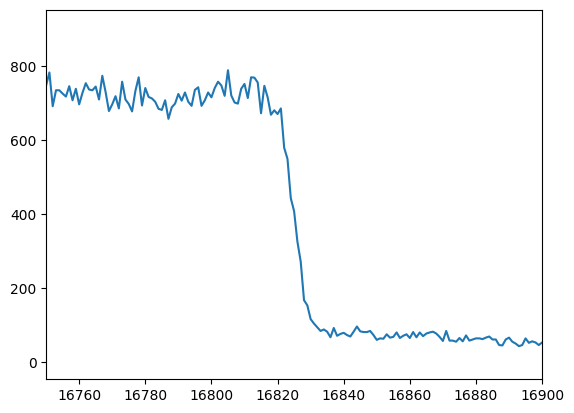

In [15]:
plt.plot(np.sum(h_NN,axis=0))
plt.xlim([16750,16900])

NN  fit: L = 653.74, x0 = 75.02, k = -0.4826, b = 68.33
TH  fit: L = 654.73, x0 = 74.86, k = -0.4958, b = 68.69
CEN fit: L = 654.26, x0 = 74.85, k = -0.5200, b = 68.95


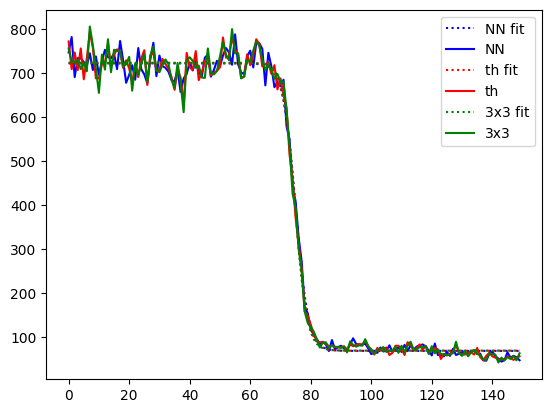

In [16]:
x0_guess = 75 #17
istart = 16750 #8395
iend = 16900

ydata_NN = np.sum(h_NN,axis=0)[istart:iend]
xdata_NN = np.arange(len(ydata_NN))
p0 = [np.mean(ydata_NN[ydata_NN > np.mean(ydata_NN)]), x0_guess, 1, min(ydata_NN)]
popt, pcov = curve_fit(sigmoid, xdata_NN, ydata_NN, p0, method='dogbox')
plt.plot(xdata_NN,sigmoid(xdata_NN,*popt),label='NN fit',color='blue',linestyle=':')
plt.plot(ydata_NN,label="NN",color='blue')
print("NN  fit: L = {:.2f}, x0 = {:.2f}, k = {:.4f}, b = {:.2f}".format(*popt))

ydata_th = np.sum(h_th,axis=0)[istart:iend]
xdata_th = np.arange(len(ydata_th))
p0 = [np.mean(ydata_th[ydata_th > np.mean(ydata_th)]), x0_guess, 1, min(ydata_th)]
popt, pcov = curve_fit(sigmoid, xdata_th, ydata_th, p0, method='dogbox')
plt.plot(xdata_th,sigmoid(xdata_th,*popt),label='th fit',color='red',linestyle=':')
plt.plot(ydata_th,label="th",color='red')
print("TH  fit: L = {:.2f}, x0 = {:.2f}, k = {:.4f}, b = {:.2f}".format(*popt))

ydata_3x3 = np.sum(h_3x3,axis=0)[istart:iend]
xdata_3x3 = np.arange(len(ydata_3x3))
p0 = [np.mean(ydata_3x3[ydata_3x3 > np.mean(ydata_3x3)]), x0_guess, 1, min(ydata_3x3)]
popt, pcov = curve_fit(sigmoid, xdata_3x3, ydata_3x3, p0, method='dogbox')
plt.plot(xdata_3x3,sigmoid(xdata_3x3,*popt),label='3x3 fit',color='green',linestyle=':')
plt.plot(ydata_3x3,label="3x3",color='green')
print("CEN fit: L = {:.2f}, x0 = {:.2f}, k = {:.4f}, b = {:.2f}".format(*popt))

# plt.plot(np.sum(h_th,axis=0),label="Threshold")
# plt.plot(np.sum(h_3x3,axis=0),label="3x3 centroid")
#plt.xlim([16800,16850])
#plt.xlim([8390,8430])
plt.legend()

In [ ]:
xcenters = np.arange(len(h1_y)-1)
plt.plot(xcenters,h1[11,:])
#plt.xlim(1650,1750)

In [ ]:
x_guess = 170
# 349 for 850 bins
r_edges, x_edges, scurves = [], [], []
for row in range(h1.shape[0]):
    
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve_row(h1,row,x_guess,rng=20)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    
    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
    
        if(not(L is None)):
            r_edges.append(row)
            x_edges.append(x_edge)
            scurves.append(h1[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0 =",x_edge)

r_edges = np.array(r_edges)
x_edges = np.array(x_edges)
scurves = np.array(scurves)

In [ ]:
final_scurve = np.sum(scurves[0:479],axis=0)
plt.plot(final_scurve)
ydata = final_scurve
xdata = np.arange(len(final_scurve))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt))
plt.xlim([25,35])
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt[0]))
print("x0 = {}".format(popt[1]))
print("k = {}".format(popt[2]))
print("b = {}".format(popt[3]))

### Threshold method

In [ ]:
summed_image.shape

In [ ]:
h2, h2_x, h2_y = np.histogram2d(c_th_all,r_th_all,range=[[0,2304],[0,3240]],bins=(230,324))
plt.imshow(h2)
plt.colorbar()

In [ ]:
xcenters = np.arange(len(h2_y)-1)
plt.plot(xcenters,h2[11,:])

In [ ]:
x_guess = 170
r_edges_th, x_edges_th, scurves_th = [], [], []
for row in range(h2.shape[0]):
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve_row(h2,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess

    x_edge = int(np.round(x0))

    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
        if(not(L is None)):
            r_edges_th.append(row)
            x_edges_th.append(x_edge)
            scurves_th.append(h2[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0")

r_edges_th = np.array(r_edges_th)
x_edges_th = np.array(x_edges_th)
scurves_th = np.array(scurves_th)

In [ ]:
final_scurve_th = np.sum(scurves_th,axis=0)
plt.plot(final_scurve_th,color='red')
plt.plot(final_scurve,color='blue')
ydata = final_scurve_th
xdata = np.arange(len(final_scurve_th))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt_th, pcov_th = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt_th),'--',color='red')
plt.plot(xdata,sigmoid(xdata,*popt),'--',color='blue')
plt.xlim([25,35])
print("# of NN scurves:",len(scurves))
print("# of th scurves:",len(scurves_th))
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt_th[0]))
print("x0 = {}".format(popt_th[1]))
print("k = {}".format(popt_th[2]))
print("b = {}".format(popt_th[3]))

# OLD ANALYSIS

#### Read the images (.dat format)

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=2):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('<H', chunk)[0]
            else:
                break    


# Read the specified number of images from the given file.
# Each "image" is the difference between two 512x512 "pre"-images
#  read in succession. Each image is median subtracted.
def read_images(datfile,nimages):
    
    # Create a reader.
    freader = iter(bytes_from_file(datfile))

    # Read 4-byte header.
    for i in range(2):
        next(freader)

    # Read the images.
    imgs = []
    for ni in range(nimages):

        img1 = []
        for i in range(512*512):
            img1.append(next(freader))

        img2 = []
        for i in range(512*512):
            img2.append(next(freader))

        imgs.append(np.array(img2).reshape([512,512]) - np.array(img1).reshape([512,512]))

    # Return the final image array in numpy format.
    imgs = np.array(imgs)
    imgs = imgs - np.median(imgs,axis=0)
    
    return imgs

In [ ]:
th = 100
all_img_proc, all_img_th_proc = [], []
datfiles = glob("/data/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles[0:1]:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Average over all images to get the "processed" image.
    img_proc = np.average(imgs,axis=0)
    all_img_proc.append(img_proc)
    
    # Threshold the images to get individual counts.
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Sum the thresholded images.
    img_th_proc = np.sum(imgs_th,axis=0)
    all_img_th_proc.append(img_th_proc)

all_img_proc = np.array(all_img_proc)
all_img_th_proc = np.array(all_img_th_proc)

In [ ]:
np.savez("all_img_arrays.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc)

In [ ]:
# Load the arrays from the file
f_img_arrays = np.load("all_img_arrays.npz")
all_img_proc = f_img_arrays['all_img_proc']
all_img_th_proc = f_img_arrays['all_img_th_proc']

In [ ]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(8.0)
fig.set_figwidth(20.0)
for iplt in range(len(all_img_th_proc)):
    iaxis = int(iplt / 8)
    jaxis = iplt % 8
    axs[iaxis,jaxis].imshow(all_img_th_proc[iplt],vmax=100)

# plt.imshow(all_img_proc[11])
# plt.colorbar()

In [ ]:
# Create the summed, thresholded image from all datasets.
img_th_all = np.sum(all_img_th_proc,axis=0)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()

In [ ]:
# Check the numbers of counts in each pixel.
plt.hist(all_img_th_proc.flatten(),bins=100)
plt.yscale('log')

#### Histogram individual image elements to determine threshold

In [ ]:
# Create a histogram of all image elements.
plt.hist(imgs.flatten(),bins=100,range=[0,400])
plt.yscale("log")

In [ ]:
# Create a thresholded image.
th = 100
imgs_th = np.zeros(imgs.shape)
imgs_th[imgs > th] = 1#imgs[imgs > th]

In [ ]:
# Show the thresholded image.
img_th_proc = np.sum(imgs_th,axis=0)
plt.imshow(img_th_proc,vmax=10) #norm=LogNorm(vmin=0.01, vmax=1))
plt.colorbar()

In [ ]:
plt.plot(img_th_proc[10,300:400])

#### Fit the edge of the thresholded image for each row

In [ ]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[nrow,xmin:xmax]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox') #, bounds=((-max(ydata), x0-20, -np.inf, 0), (max(ydata), x0+20, np.inf, 200)))
    
    return popt

In [ ]:
x_guess = 357 #357 210
x_edges = []
for row in range(img_th_all.shape[0]):
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(img_th_all,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = -1
    
    # Append this fit result for x0 to the list.
    x_edge = x0 # int(np.round(x0))
    x_edges.append(x_edge)
    
    # Update the guess if the fit was successful (otherwise keep the last guess)
    if(x0 > 0):
        x_guess = int(np.round(x_edge))
        
    print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
x_edges = np.array(x_edges)

In [ ]:
# Set all -1 values as average of left and right values.
i = 1
tol = 1
while(i < len(x_edges)-2):
    v = x_edges[i]
    vleft = x_edges[i-1]
    vright = x_edges[i+1]
    
    # Do not process this value with an invalid value to the right.
    if(vright < 0):
        i += 1
        continue
        
    if(v < 0):
        x_edges[i] = (vleft + vright)/2.
        print("-> vleft = {}, vright = {}, v = {}".format(vleft,vright,v))
        print("-- Set negative x_edge value at i = {} to left/right avg value {}".format(i,(vleft+vright)/2))
    elif(abs(vleft - v) > tol and abs(vright - v) > tol):
        x_edges[i] = (vleft + vright)/2.
        print("-> vleft = {}, vright = {}, v = {}".format(vleft,vright,v))
        print("-- Set outlier x_edge value at i = {} to left/right avg value {}".format(i,(vleft+vright)/2))
        
    i += 1

##### Plot the edge

In [ ]:
img_edge = np.zeros([512,512]) #img_th_all.shape)
for row,xedge in zip(range(img_edge.shape[0]),x_edges):
    iedge = int(np.round(xedge))
    img_edge[row,iedge] = 1

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()
#plt.imshow(img_edge,alpha=0.1)

ax2 = fig.add_subplot(122)
plt.imshow(img_edge)

##### Test a single fit

In [ ]:
row = 0
x_guess = 210
rng = 50

popt = fit_scurve(img_th_all,row,x_guess)

xmin = max(0,x_guess-rng)
xmax = min(img_th_all.shape[1],x_guess+rng)
ydata = img_th_all[row,xmin:xmax]
xdata = np.arange(xmin,xmax)

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.xlabel("Image column")
plt.ylabel("Counts")

print("-- Fit row",row,": popt =",popt)
print(np.mean(ydata[ydata > np.mean(ydata)]))

In [ ]:
# Save all arrays.
np.savez("iimg_arrays_0_right.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc,x_edges=x_edges)

##### Select the images using the edge array

In [ ]:
f_img_arrays = np.load("img_arrays_0_right.npz")
x_edges = f_img_arrays['x_edges']
side = 0 # 0 = right, 1 = left

In [ ]:
def line(x, m, b):
    y = m*x + b
    return y

# Determines whether the image is a valid event.
def check_subimage_th(subimg):
    valid = False
    
    # Ensure the maximum pixel index is within some number of pixels of the borders.
    pixel_padding = 1
    max_index = np.unravel_index(subimg.argmax(),subimg.shape)
    valid = (max_index[0] > pixel_padding) and (max_index[0] < subimg.shape[0]-pixel_padding-1) and (max_index[1] > pixel_padding) and (max_index[1] < subimg.shape[1]-pixel_padding-1)
    
    # Ensure there is at least 1 nonzero pixel.
    valid = valid and (len(subimg[subimg > 0]) > 0) 
    
    return valid

def choose_subimages(img, img_th, available_edges, debug=False):

    valid_subimages, valid_subimages_c, valid_subimages_th = [], [], []
    line_m, line_b = [], []

    # Loop until no available edges remain.
    done = (available_edges == -1).all()
    while(not done):

        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)

        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue

        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            
            done = (available_edges == -1).all()
            continue

        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):

            # Construct the subimage.
            xmid = int(np.round(x_edges[rmid]))
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1

            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):

                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[0] - delta)
                jleft = cstart + (arg_max[1] - delta)
                iright = rend + (arg_max[0] - delta)
                jright = cend + (arg_max[1] - delta)

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):

                    # Compute the slopes and intercepts.
                    xfit,yfit = [], []
                    y1 = 0.5; y2 = (rend - rstart) - 0.5
                    x1 = (x_edges[rstart] - cstart) + 0.5; x2 = (x_edges[rend] - cstart) + 0.5
                    m0 = (y2 - y1) / (x2 - x1)
                    b0 = y2 - m0*x2
                    for i,y in enumerate(np.arange(y1,y2+1)):
                        x = (x_edges[rstart + i] - cstart) + 0.5
                        xfit.append(x)
                        yfit.append(y)
                    p0 = [m0, b0]
                    popt, pcov = curve_fit(line, xfit, yfit, p0)
                    m = popt[0]
                    b = popt[1]
                    if(debug): 
                        print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                        print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                        print("m0 = {}, b0 = {}".format(m0,b0))
                        print("m = {}, b = {}".format(m,b))
                        
                        # Make a plot of the image + points + fit.
                        fig = plt.figure()
                        fig.set_figheight(4.0)
                        fig.set_figwidth(8.0)
                        xplt = np.arange(0,2*subimg_halfsize,1e-4)
                        yplt = m*xplt + b

                        plt.imshow(subimg, extent=[0,2*subimg_halfsize+1,2*subimg_halfsize+1,0])
                        plt.plot(xplt[(yplt >= 0) & (yplt < 2*subimg_halfsize+1)],yplt[(yplt >= 0) & (yplt < 2*subimg_halfsize+1)],linewidth=2,color='red')
                        plt.plot(xfit,yfit,'.',color='red')
                        plt.title("m0 = {}, b0 = {},\nm = {}, b = {}".format(m0,b0,m,b))
                        plt.savefig("plt/subimg_xmid_{}.png".format(xmid))
                        plt.close()
                    
# Old version                    
#                     x1 = (x_edges[rstart] - cstart) + 0.5
#                     x2 = (x_edges[rend] - cstart) + 0.5
#                     if(x2 == x1): 
#                         if(side == 0): x2 = x1-1
#                         else: x2 = x1+1
#                     y1 = 0.5
#                     y2 = (rend - rstart) - 0.5
#                     m = (y2 - y1) / (x2 - x1)
#                     b = y2 - m*x2
#                     if(debug): print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
#                     if(debug): print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    
                    # Only save the subimage if the slope is negative for side = 0 or positive for side = 1.
                    # (Note, because y increases downward, the notion of "negative" and "positive" is flipped.)
                    if(debug): print("side = {}, m = {}".format(side,m))
                    if((side == 0 and m < 0) or (side == 1 and m > 0)):

                        # Save the subimage if the centered subimage is also valid.
                        if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                            if(debug): print("Centered subimage is valid.")
                            subimg_c = img[ileft:iright,jleft:jright]
                            arg_max_c = np.unravel_index(np.argmax(subimg_c),subimg_c.shape)

                            # Don't save the image if the center pixel is no longer the maximum.
                            if(arg_max_c[0] == delta and arg_max_c[1] == delta):
                                if(debug): print("Center pixel is no longer maximum: ADDING IMAGE")
                                valid_subimages.append(subimg)
                                valid_subimages_c.append(subimg_c)
                                valid_subimages_th.append(subimg_th)
                                line_m.append(m)
                                line_b.append(b)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.

            else:
                available_edges[rstart:rend] = -1

        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1

        # Set the terminating condition.
        done = (available_edges == -1).all()
        #if(debug): print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))
    
    # Return the arrays.
    valid_subimages = np.array(valid_subimages)
    valid_subimages_c = np.array(valid_subimages_c)
    valid_subimages_th = np.array(valid_subimages_th)
    line_m = np.array(line_m)
    line_b = np.array(line_b)
    
    return valid_subimages, valid_subimages_c, valid_subimages_th, line_m, line_b

In [ ]:
debug_flag = False

th = 100
subimg_halfsize = 5
rmin = 0
rmax = len(x_edges)
cmin = 0
cmax = len(x_edges) # assume image is square

valid_subimages, valid_subimages_c, valid_subimages_th = None, None, None
line_m, line_b = None, None

datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles: #[2:3]:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Threshold the images to get individual counts
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Get all subimages from each image.
    for iimg in range(len(imgs)):
        if(iimg % 200 == 0): print("--> Processing image",iimg,"of",len(imgs))
        
        # Get this image and its thresholded version.
        img = imgs[iimg]
        img_th = imgs_th[iimg]
        
        # Create a new array of available edges.
        available_edges = np.ones(len(x_edges))
        
        # Get the subimages.
        t_valid_subimages, t_valid_subimages_c, t_valid_subimages_th, t_line_m, t_line_b = choose_subimages(img, img_th, available_edges, debug = debug_flag)
        
        # Only add to the main arrays if there are additional subimages.
        if(t_valid_subimages.ndim == 3):
        
            if(valid_subimages is None): valid_subimages = t_valid_subimages
            else: valid_subimages = np.append(valid_subimages, t_valid_subimages, axis=0)
            if(valid_subimages_c is None): valid_subimages_c = t_valid_subimages_c
            else: valid_subimages_c = np.append(valid_subimages_c, t_valid_subimages_c, axis=0)
            if(valid_subimages_th is None): valid_subimages_th = t_valid_subimages_th
            else: valid_subimages_th = np.append(valid_subimages_th, t_valid_subimages_th, axis=0)
            if(line_m is None): line_m = t_line_m
            else: line_m = np.append(line_m, t_line_m, axis=0)
            if(line_b is None): line_b = t_line_b
            else: line_b = np.append(line_b, t_line_b, axis=0)
                
        else:
            print("WARNING: did not add any new subimages for image",iimg)
        
    del imgs
    del imgs_th
    gc.collect()

# Convert to numpy arrays.
# valid_subimages = np.array(valid_subimages)
# valid_subimages_th = np.array(valid_subimages_th)
# line_m = np.array(line_m)
# line_b = np.array(line_b)

In [ ]:
valid_subimages_c.shape

In [ ]:
line_m.shape

In [ ]:
plt.hist2d(line_m,line_b)

In [ ]:
np.savez("subimgs_537k_right.npz",valid_subimages=valid_subimages,valid_subimages_c=valid_subimages_c,valid_subimages_th=valid_subimages_th,line_m=line_m,line_b=line_b)

In [ ]:
# Load the subimages
fn = np.load("subimgs_537k_right.npz")
valid_subimages = fn['valid_subimages']
valid_subimages_c = fn['valid_subimages_c']
valid_subimages_th = fn['valid_subimages_th']
line_m = fn['line_m']
line_b = fn['line_b']

In [ ]:
isub = 16
nrows = ncols = 11

In [ ]:
# Plot subimages.
mm = line_m[isub]
bb = line_b[isub]
xfit = np.arange(0,ncols-1,1e-4)
yfit = mm*xfit + bb

plt.imshow(valid_subimages[isub])
plt.plot(xfit[(yfit >= 0) & (yfit < nrows-1)],yfit[(yfit >= 0) & (yfit < nrows-1)],linewidth=2,color='red')
print("Slope is",mm,"and intercept is",bb)

In [ ]:
plt.imshow(valid_subimages_th[isub])
#plt.imshow(np.sum(valid_subimages_th,axis=0))

In [ ]:
len(valid_subimages)

#### Train the NN

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_500k_1600.pt".format(modeldir)

# Create the dataset.
dataset_train = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_521k_left.npz",
                                    "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_537k_right.npz",
                                    0,400000)
dataset_val = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_521k_left.npz",
                                  "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_537k_right.npz",
                                  400000,100000)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=False, collate_fn=tr.my_collate_reg_line_realdata, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    for m in model.modules():
        for child in m.children():
            if type(child) == nn.BatchNorm2d:
                child.track_running_stats = False
                child.running_mean = None
                child.running_var = None
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, 1000)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

##### Look at individual events

In [ ]:
# Look at individual events
evt_plt = 12
evt_item = dataset_val[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
evt_line_m     = evt_item[5]
evt_line_b     = evt_item[6]
print("Light side is",evt_lside)
print("Arg max is",evt_argmax)

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5
row_th   = evt_argmax[0] + 0.5
col_th   = evt_argmax[1] + 0.5
print("Pred point (",col_pred,",",row_pred,")")
print("Pred vector (",pred_err[0],",",pred_err[1],")")
print("Max point (",col_th,",",row_th,")")

# Compute the distance from the reconstructed point to the line.
dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
#ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax2 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
#ax2.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax2.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
batch_size = 1
indices = np.indices((emnet.EVT_SIZE,emnet.EVT_SIZE))
row_coords = torch.tensor(indices[0] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
col_coords = torch.tensor(indices[1] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist, dist_reco_masked = tr.loss_reg_edge(data.squeeze(1), torch.tensor(evt_item[3]).unsqueeze(0).cuda(), output_score, row_coords, col_coords, torch.tensor([evt_argmax]).cuda(), evt_line_m, evt_line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

ax3 = fig.add_subplot(133)
plt.imshow(dist_reco_masked.cpu().detach().squeeze(0).numpy(),extent=[0,11,11,0])
#ax3.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax3.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Cluster")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b

print("COMPARE LOSS")
if(evt_lside == 1):
    dist_pred *= -1
sigma_dist = 2
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-dist_pred/sigma_dist)
print("-- Distance is:",dist_pred)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

## Evaluate distance to line for different reconstructions

In [ ]:
ldist_pred, ldist_th = [], []
debug = False
for evt in range(len(dataset_val)):
    
    evt_item = dataset_val[evt]
    evt_frame_cmax = np.array(evt_item[0])
    evt_frame      = np.array(evt_item[1])
    evt_argmax     = np.array(evt_item[2])
    evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
    evt_lside      = np.array(evt_item[4])
    evt_line_m     = evt_item[5]
    evt_line_b     = evt_item[6]
    if(debug): print("Evt {}: Light side is {}, arg max is {}".format(evt,evt_lside,evt_argmax))

    # Information for drawing the line.
    nrows = evt_frame.shape[0]
    ncols = evt_frame.shape[1]
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    if(debug): print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

    # Run the model and compute the reconstructed point.
    data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
    row_pred = pred_err[1] + evt_argmax[0] + 0.5
    col_pred = pred_err[0] + evt_argmax[1] + 0.5
    if(debug): print("Pred point (",col_pred,",",row_pred,")")
    if(debug): print("Pred vector (",pred_err[0],",",pred_err[1],")")
    
    # Compute the distance from the reconstructed point to the line.
    dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
    dist_pred *= 1-2*evt_lside
    if(debug): print("Predicted distance to the line:",dist_pred)
    
    # Determine the max threshold point and its distance to the line.
    row_th   = evt_argmax[0] + 0.5
    col_th   = evt_argmax[1] + 0.5
    dist_th = (evt_line_m*col_th - row_th + evt_line_b) / (evt_line_m**2 + 1)**0.5
    dist_th *= 1-2*evt_lside
    if(debug): print("Threshold point (",col_th,",",row_th,")")
    if(debug): print("Threshold distance to the line:",dist_th)
    
    ldist_pred.append(dist_pred)
    ldist_th.append(dist_th)

In [ ]:
rng = [-6,6]
nbins = 80
plt.hist(ldist_pred,bins=nbins,label="NN",range=rng,alpha=0.7,color='blue')
plt.hist(ldist_th,bins=nbins,label="max charge",range=rng,alpha=0.7,color='green')
#plt.yscale('log')
plt.legend()
plt.ylabel("Counts/bin")
plt.xlabel("Distance from line (pixels)")

## Evaluation/reconstruction of images

In [ ]:
th = 100
subimg_halfsize = 5
rmin = 0; rmax = 511
cmin = 0; cmax = 511

r_th, c_th = [], []
r_NN, c_NN = [], []
datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Threshold the images to get individual counts
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # For each point in the thresholded image, attempt to get an 11x11 subimage.
    for iimg in range(len(imgs_th)):
        
        # print("-- Image index",iimg)
        
        i_subimgs, r_subimgs, c_subimgs = [], [], []
        
        r_nz, c_nz = np.nonzero(imgs_th[iimg])
        # print("---> Number of nonzero indices:",len(r_nz))
        
        for r,c in zip(r_nz,c_nz):
            
#             rnz, cnz = np.nonzero(imgs_th[iimg])
#             print("---> Number of nonzero indices:",len(rnz))
            
            # If we've already erased this index, skip it.
            if(imgs_th[iimg,r,c] == 0):
                continue

            rstart = r - subimg_halfsize
            rend = r + subimg_halfsize + 1
            cstart = c - subimg_halfsize
            cend = c + subimg_halfsize + 1

            # Ensure we can select an 11x11 subimage.
            if((rstart >= rmin) and (rend <= rmax) and (cstart >= cmin) and (cend <= cmax)):
                
                # Get the subimage.
                subimg = imgs[iimg,rstart:rend,cstart:cend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[0] - delta)
                jleft = cstart + (arg_max[1] - delta)
                iright = rend + (arg_max[0] - delta)
                jright = cend + (arg_max[1] - delta)
                
                # Compute the central pixel values relative to the main image.
                rcenter = r + (arg_max[0] - delta)
                ccenter = c + (arg_max[1] - delta)
                
                # Ensure we can still select the 11x11 subimage.
                if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                
                    # Zero all indices in the thresholded image.
                    imgs_th[iimg,ileft:iright,jleft:jright] = 0
                    
                    # Select the final subimage.
                    subimg = imgs[iimg,ileft:iright,jleft:jright]
                    
                    # Add to the array of subimages for this image.
                    i_subimgs.append(subimg)
                    r_subimgs.append(rcenter)
                    c_subimgs.append(ccenter)
                    
        i_subimgs = np.array(i_subimgs)
        r_subimgs = np.array(r_subimgs)
        c_subimgs = np.array(c_subimgs)
        
        # Reconstruct a single point for all subimages.
        data = torch.tensor(i_subimgs).float().unsqueeze(1).cuda()
        output_score = model(data)
        pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
        row_pred = r_subimgs + 0.5 + pred_err[:,1]
        col_pred = c_subimgs + 0.5 + pred_err[:,0]
        
        # Save the reconstructed points for this image.
        r_th.append(r_subimgs + 0.5)
        c_th.append(c_subimgs + 0.5)
        r_NN.append(row_pred)
        c_NN.append(col_pred)

In [ ]:
r_NN_all = np.concatenate(r_NN)
c_NN_all = np.concatenate(c_NN)
r_th_all = np.concatenate(r_th)
c_th_all = np.concatenate(c_th)

In [ ]:
np.savez("areco_pts.npz",r_NN_all=r_NN_all,c_NN_all=c_NN_all,r_th_all=r_th_all,c_th_all=c_th_all)

In [ ]:
fn = np.load('reco_pts.npz')

In [ ]:
r_NN_all = fn['r_NN_all']
c_NN_all = fn['c_NN_all']
r_th_all = fn['r_th_all']
c_th_all = fn['c_th_all']

### S-curve fits for NN method

In [ ]:
h1, h1_x, h1_y = np.histogram2d(c_NN_all,r_NN_all,range=[[0,512],[0,512]],bins=(512,512))
plt.imshow(h1.T,vmax=500)
plt.colorbar()

In [ ]:
#xcenters = (h1_x[:-1] + h1_x[1:])/2
xcenters = np.arange(len(h1_x)-1)
plt.plot(xcenters,h1[:,10])
plt.xlim(180,230)

In [ ]:
x_guess = 210
# 349 for 850 bins
r_edges, x_edges, scurves = [], [], []
for row in range(h1.T.shape[1]):
    
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(h1.T,row,x_guess,rng=20)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    
    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
    
        if(not(L is None)):
            r_edges.append(row)
            x_edges.append(x_edge)
            scurves.append(h1.T[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0 =",x_edge)

r_edges = np.array(r_edges)
x_edges = np.array(x_edges)
scurves = np.array(scurves)

In [ ]:
final_scurve = np.sum(scurves[0:479],axis=0)
plt.plot(final_scurve)
ydata = final_scurve
xdata = np.arange(len(final_scurve))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt))
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt[0]))
print("x0 = {}".format(popt[1]))
print("k = {}".format(popt[2]))
print("b = {}".format(popt[3]))

### S-curve fits for threshold method

In [ ]:
h2, h2_x, h2_y = np.histogram2d(c_th_all,r_th_all,range=[[0,512],[0,512]],bins=(512,512))
plt.imshow(h2.T,vmax=100)
plt.colorbar()

In [ ]:
xcenters = (h2_x[:-1] + h2_x[1:])/2
plt.plot(xcenters,h2[:,10])
plt.xlim(200,240)

In [ ]:
x_guess = 210
r_edges_th, x_edges_th, scurves_th = [], [], []
for row in range(h2.T.shape[1]):
    
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(h2.T,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
    
        if(not(L is None)):
            r_edges_th.append(row)
            x_edges_th.append(x_edge)
            scurves_th.append(h2.T[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0")

r_edges_th = np.array(r_edges_th)
x_edges_th = np.array(x_edges_th)
scurves_th = np.array(scurves_th)

In [ ]:
final_scurve_th = np.sum(scurves_th,axis=0)
plt.plot(final_scurve_th,color='red')
plt.plot(final_scurve,color='blue')
ydata = final_scurve_th
xdata = np.arange(len(final_scurve_th))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt_th, pcov_th = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt_th),'--',color='red')
plt.plot(xdata,sigmoid(xdata,*popt),'--',color='blue')
plt.xlim([25,35])
print("# of NN scurves:",len(scurves))
print("# of th scurves:",len(scurves_th))
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt_th[0]))
print("x0 = {}".format(popt_th[1]))
print("k = {}".format(popt_th[2]))
print("b = {}".format(popt_th[3]))

## Backup code

In [ ]:
plt.imshow(subimg)
plt.colorbar()

In [ ]:
x0 = 105
nrow = 5
rng = 20
xmin = max(0,x0-rng)
xmax = min(h1.T.shape[1],x0+rng)
ydata = h1.T[nrow,xmin:xmax]
xdata = np.arange(xmin,xmax)

# Set an initial guess and perform the fit.
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')

In [ ]:
plt.plot(xdata,ydata)

In [ ]:
xcenters = (h1_x[:-1] + h1_x[1:])/2
plt.plot(xcenters,h1.T[3,:])
plt.xlim(200,240)

In [ ]:
#plt.imshow(np.average(imgs_medsub,axis=0))
plt.imshow(imgs_th[0][0:11,0:11])
plt.colorbar()

In [ ]:
subimg_halfsize = 5
rmin = 0
rmax = len(available_edges)
cmin = 0
cmax = imgs_th.shape[2]
    
# For each individual thresholded image, choose the sub-images.
valid_subimages_th, valid_subimages = [], []
line_m, line_b = [], []
for iimg in range(1): #len(imgs_th.shape[0]))
    
    img    = imgs[iimg]
    img_th = imgs_th[iimg]
    
    done = (available_edges == -1).all()

    while(not done):
        
        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)
        
        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue
        
        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            continue
        
        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):
        
            # Construct the subimage.
            xmid = x_edges[rmid]
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1
            
            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):
                
                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):
                    
                    # Compute the slopes and intercepts.
                    x1 = (x_edges[rstart] - cstart) + 0.5
                    x2 = (x_edges[rend] - cstart) + 0.5
                    if(x2 == x1): x2 = x1-1
                    y1 = 0.5
                    y2 = (rend - rstart) - 0.5
                    m = (y2 - y1) / (x2 - x1)
                    b = y2 - m*x2
                    print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                    print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    line_m.append(m)
                    line_b.append(b)

                    # Save the subimage.
                    valid_subimages.append(subimg)
                    valid_subimages_th.append(subimg_th)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.
                
            else:
                available_edges[rstart:rend] = -1
           
        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1
        
        # Set the terminating condition.
        done = (available_edges == -1).all()
        print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))

line_m = np.array(line_m)
line_b = np.array(line_b)
valid_subimages = np.array(valid_subimages)
valid_subimages_th = np.array(valid_subimages_th)

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

# Fit the S-curve to a sigmoid.
def fit_scurve():
    

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th02_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_edge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))